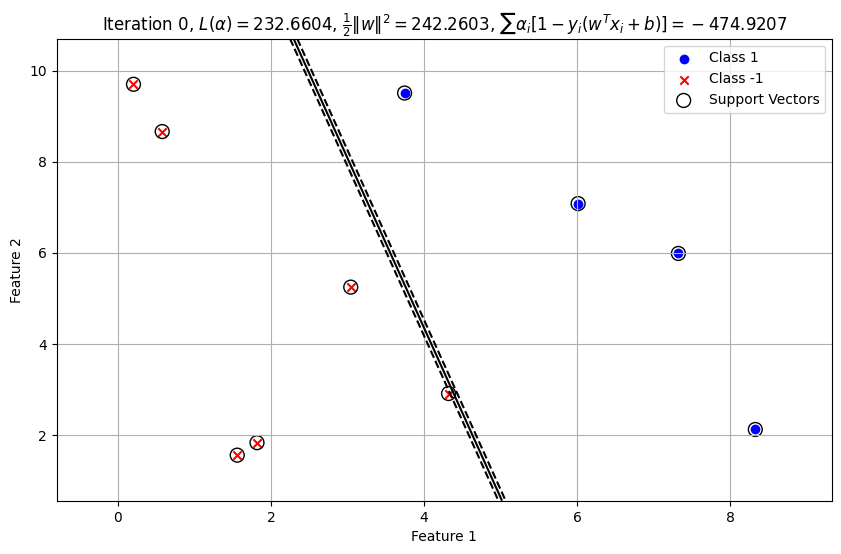

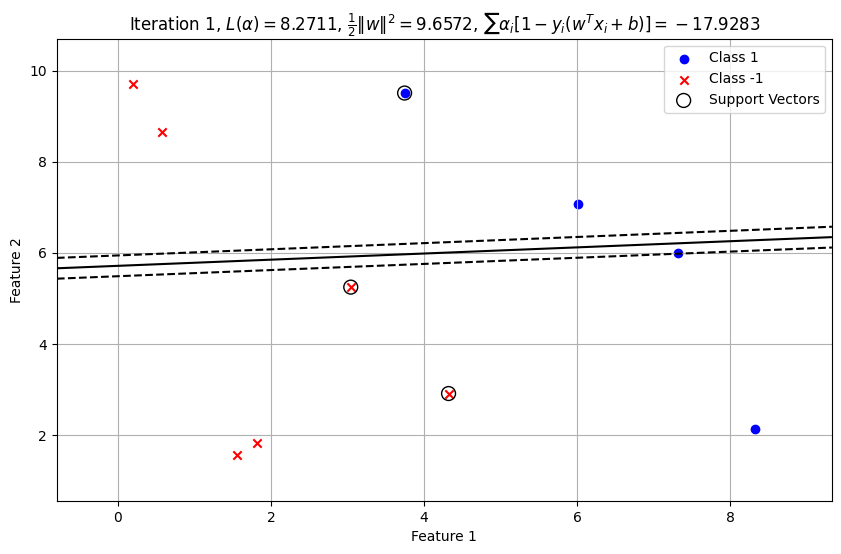

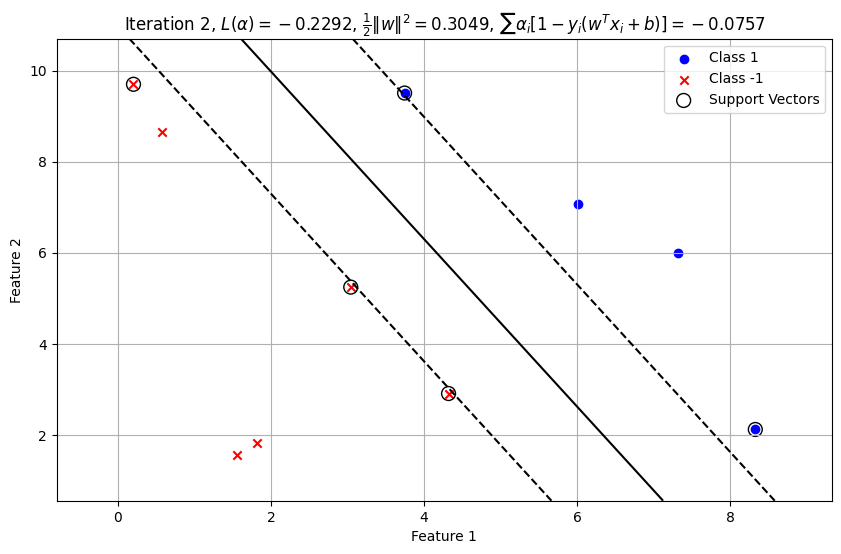

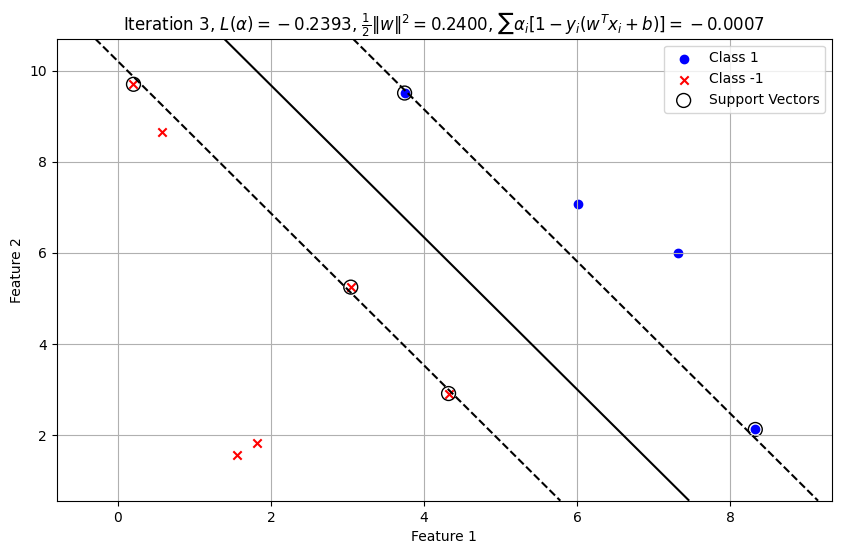

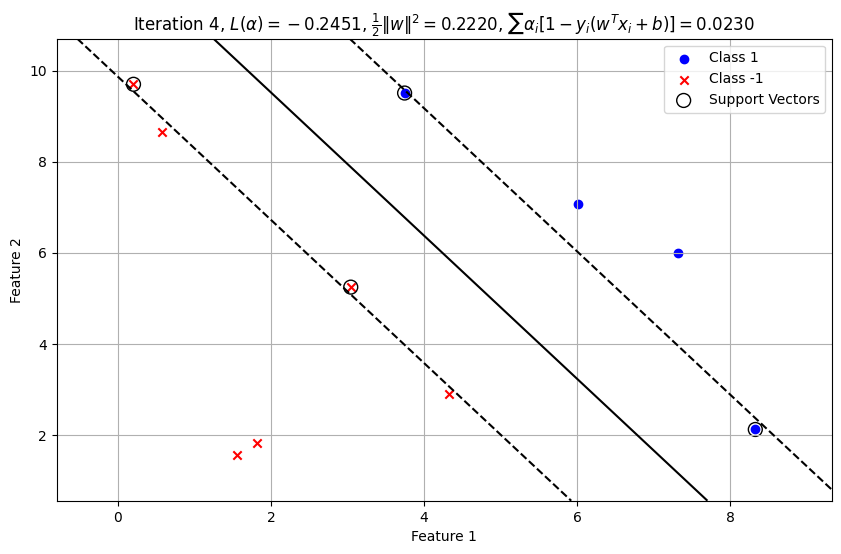

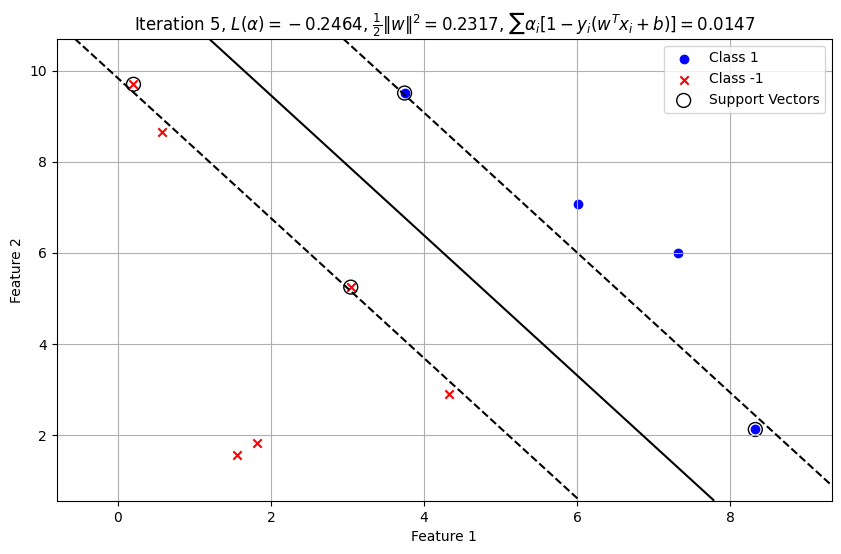

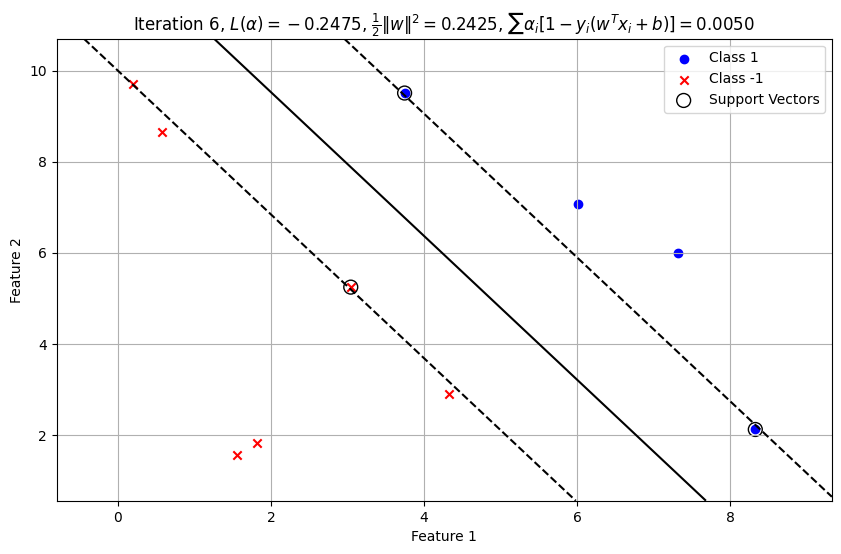

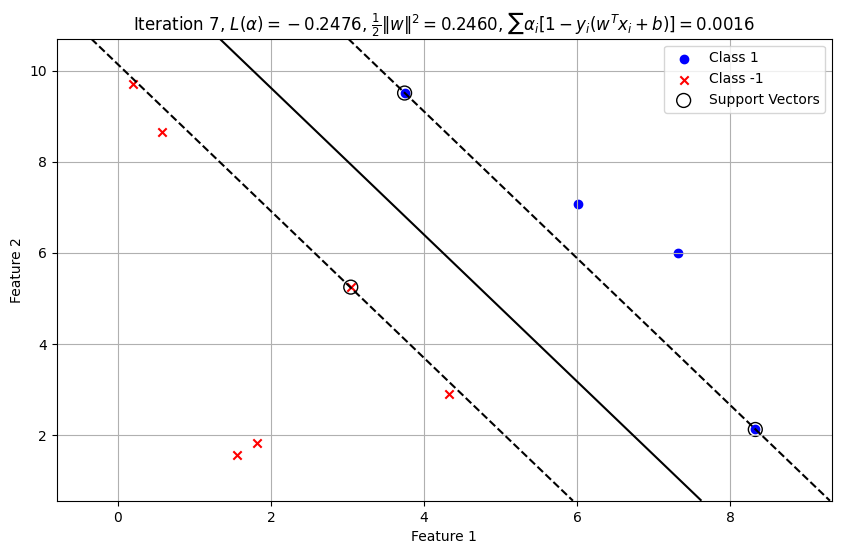

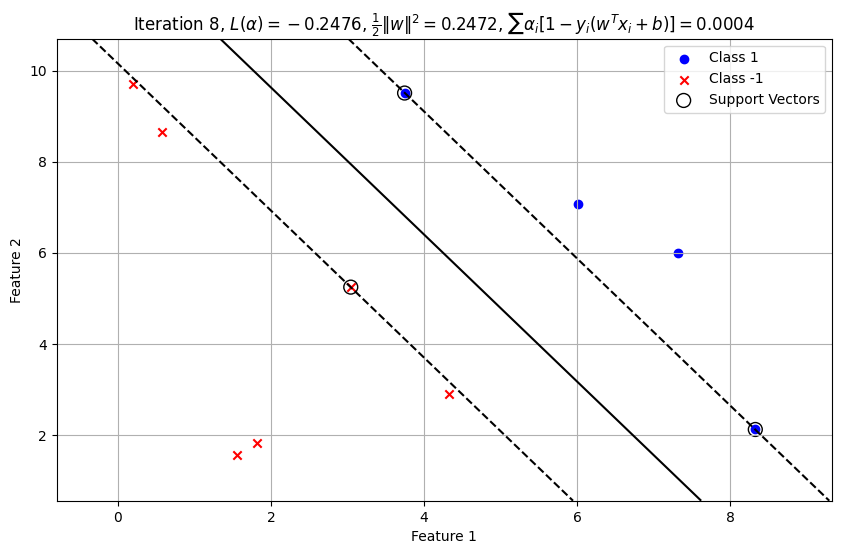

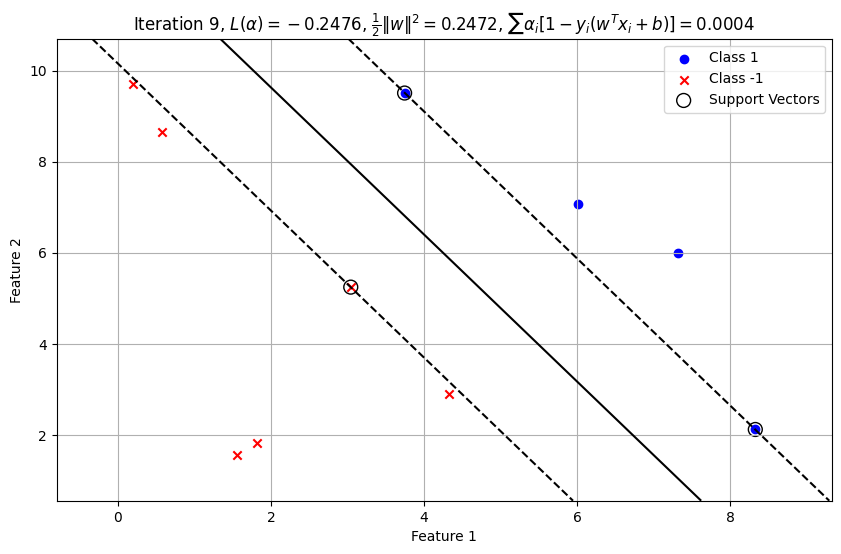

In [6]:
import numpy as np
from numpy.linalg import norm
from scipy.optimize import minimize
import matplotlib.pyplot as plt

# List to store objective values and alpha values at each iteration
objective_history = []
alpha_history = []
iteration_number = 0

def svm_train(X, y):
    """
    Train an SVM model using numpy and scipy to solve the dual problem,
    and store the values of alpha and objective function at each step for hard-margin SVM.
    
    Parameters:
    X -- (m x n) matrix of m samples with n features
    y -- (m,) vector of class labels (-1 or 1)
    
    Returns:
    alpha -- Lagrange multipliers
    w -- weight vector
    b -- bias term
    """
    m, n = X.shape
    
    # Gram matrix of X (i.e., pairwise dot products between samples)
    K = X @ X.T
    
    # Objective function for dual problem (no slack variables since hard-margin)
    def objective(alpha):
        obj = 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K) - np.sum(alpha)
        objective_history.append(obj)  # Store objective function value
        return obj

    # Constraints: sum(alpha_i * y_i) = 0
    constraints = {'type': 'eq', 'fun': lambda alpha: np.dot(alpha, y)}
    
    # Bounds: 0 <= alpha_i <= C (set C to infinity for hard margin)
    bounds = [(0, np.inf) for _ in range(m)]
    
    # Initial guess for alpha
    alpha_0 = np.zeros(m)
    
    # Callback function to store the alpha values at each iteration
    def callback(alpha):
        global iteration_number
        alpha_history.append(alpha.copy())  # Store a copy of alpha at each step
        plot_decision_boundary(X, y, alpha, K, iteration_number)  # Plot during each iteration
        iteration_number += 1

    # Solve the quadratic program
    result = minimize(objective, alpha_0, bounds=bounds, constraints=constraints, callback=callback)
    alpha = result.x
    
    # Compute weight vector w
    w = np.sum((alpha * y)[:, None] * X, axis=0)
    
    # Identify support vectors (where alpha_i > 1e-5)
    support_vectors = np.where(alpha > 1e-5)[0]
    n_S = len(support_vectors)  # Number of support vectors
    
    # Compute bias term b by averaging over all support vectors
    b = np.mean([y[i] - np.dot(w, X[i]) for i in support_vectors])
    
    return alpha, w, b

def compute_dual_objective(alpha, y, K):
    """
    Compute the dual objective L(alpha) given the alphas, labels y, and Gram matrix K.
    L(alpha) = -sum(alpha) + 0.5 * sum_i sum_j alpha_i * alpha_j * y_i * y_j * K_ij
    """
    first_term = -np.sum(alpha)
    second_term = 0.5 * np.sum((alpha * y)[:, None] * (alpha * y)[None, :] * K)
    return first_term + second_term

def plot_decision_boundary(X, y, alpha, K, iteration):
    """
    Plot the decision boundary and support vectors after each iteration.
    
    Parameters:
    X -- (m x n) matrix of features
    y -- (m,) vector of class labels (-1 or 1)
    alpha -- Lagrange multipliers
    K -- Gram matrix of X
    iteration -- current iteration number
    """
    plt.figure(figsize=(10, 6))
    
    # Compute weight vector w from current alpha
    w = np.sum((alpha * y)[:, None] * X, axis=0)
    
    # Compute margin width
    margin_width = 2 / norm(w)
    
    # Identify support vectors (where alpha_i > 1e-5)
    support_vectors = np.where(alpha > 1e-5)[0]
    
    # Compute bias term b by averaging over all support vectors
    b = np.mean([y[i] - np.dot(w, X[i]) for i in support_vectors])
    
    # Calculate ||w||^2 / 2
    w_norm = 0.5 * norm(w) ** 2
    
    # Calculate the sum for alpha * (1 - y_i * (w^T x + b))
    lagrange_sum = np.sum(alpha * (1 - y * (X @ w + b)))
    
    # Calculate dual objective L(alpha)
    dual_objective = compute_dual_objective(alpha, y, K)
    
    # Plot points
    plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='b', marker='o', label="Class 1")
    plt.scatter(X[y == -1][:, 0], X[y == -1][:, 1], color='r', marker='x', label="Class -1")
    
    # Highlight support vectors
    plt.scatter(X[support_vectors][:, 0], X[support_vectors][:, 1], s=100, facecolors='none', edgecolors='k', label="Support Vectors")
    
    # Create a grid to plot decision boundary
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 500), np.linspace(y_min, y_max, 500))
    
    # Compute decision boundary
    Z = np.dot(np.c_[xx.ravel(), yy.ravel()], w) + b
    Z = Z.reshape(xx.shape)
    
    # Plot decision boundary and margins
    plt.contour(xx, yy, Z, levels=[-1, 0, 1], linestyles=['--', '-', '--'], colors='k')
    
    # Add iteration number, dual objective, and other formulas to title (with LaTeX formatting)
    plt.title(f'Iteration {iteration}, $L(\\alpha) = {dual_objective:.4f}$, $\\frac{{1}}{{2}} \\|w\\|^2 = {w_norm:.4f}$, ' +
              f'$\\sum \\alpha_i [1 - y_i(w^T x_i + b)] = {lagrange_sum:.4f}$')
    
    plt.xlabel('Feature 1')
    plt.ylabel('Feature 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Generate 10 random points for X and labels y
np.random.seed(42)  # For reproducibility
X = np.random.rand(10, 2) * 10  # Generate 10 points in 2D space (scaled by 10)
y = np.where(X[:, 0] + X[:, 1] > 10, 1, -1)  # Assign labels based on a simple condition

# Set up SVM for hard margin by using C as np.inf (effectively hard-margin)
alpha, w, b = svm_train(X, y)